3 - Seja o conjunto de dados disponibilizado na pasta Questão 3 (imagens e anotações em arquivo .json associado à construções, sobre imagens satelitais), implemente algum modelo responsável pela segmentação das residências presentes as imagens satelitais disponibilizadas.

In [5]:
import os
import cv2
import json
import numpy as np
import random

## SEPARANDO SUB AMOSTRAGEM 2MIL IMAGENS

In [6]:
annotations_paths = ['../ex3/building/annotation.json', '../ex3/building/annotation-small.json']
images_folder = '../ex3/building/train/images/'

# Lista para armazenar os image_id selecionados
selected_image_ids = []

# Dicionário para armazenar as anotações das imagens selecionadas
selected_image_annotations = {}

# Primeiro, coletamos todos os image_ids únicos
all_image_ids = set()

for annotations_path in annotations_paths:
    with open(annotations_path, 'r') as f:
        data = json.load(f)

    for annotation in data['annotations']:
        all_image_ids.add(annotation['image_id'])

# Em seguida, selecionamos aleatoriamente 2000 image_ids diferentes, se houver pelo menos 2000 disponíveis
if len(all_image_ids) >= 2000:
    selected_image_ids = random.sample(all_image_ids, k=300)
else:
    selected_image_ids = list(all_image_ids)

# Por fim, carregamos as anotações correspondentes aos image_ids selecionados
for annotations_path in annotations_paths:
    with open(annotations_path, 'r') as f:
        data = json.load(f)

    for annotation in data['annotations']:
        image_id = annotation['image_id']
        if image_id in selected_image_ids:
            if image_id not in selected_image_annotations:
                selected_image_annotations[image_id] = []
            selected_image_annotations[image_id].append(annotation)


/tmp/ipykernel_4282/2189794528.py:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_image_ids = random.sample(all_image_ids, k=300)


## CONVERTER PARA NOTAÇÃO YOLO

In [7]:
def convert_to_yolo_annotation(image_path, annotations, output_dir):
    yolo_annotations = []

    # Carregar a imagem para obter a altura e a largura
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    for annotation in annotations:
        class_index = 0  # Definir todas as classes como 0
        segmentation = annotation['segmentation'][0]  # Pegar apenas a primeira segmentação

        # Normalizar as coordenadas de segmentação para o intervalo [0, 1]
        normalized_segmentation = [coord / height if i % 2 == 0 else coord / width for i, coord in enumerate(segmentation)]

        # Adicionar anotação no formato YOLO
        yolo_annotations.append([class_index, *normalized_segmentation])

    # Salvar as anotações no arquivo de texto
    txt_filename = os.path.splitext(os.path.basename(image_path))[0] + '.txt'
    txt_path = os.path.join(output_dir, txt_filename)
    with open(txt_path, 'w') as txt_file:
        for annotation in yolo_annotations:
            line = ' '.join([str(x) for x in annotation])
            txt_file.write(line + '\n')

def save_yolo_labels(image_path, annotations, output_dir):
    if annotations:  # Verificar se há anotações
        convert_to_yolo_annotation(image_path, annotations, output_dir)
    else:
        print(f"Aviso: Não há anotações para a imagem '{image_path}'")

def process_images_annotations(image_annotations, images_folder, output_image_folder, output_label_folder):
    for image_id, annotations_list in image_annotations.items():
        image_name = str(image_id).zfill(12) + '.jpg'  # Preencher com zeros à esquerda para ter 12 dígitos
        image_path = os.path.join(images_folder, image_name)
        output_image_path = os.path.join(output_image_folder, image_name)

        if not os.path.exists(image_path):
            print(f"Aviso: Imagem '{image_path}' não encontrada")
            continue

        image = cv2.imread(image_path)
        if image is None:
            print(f"Erro: Não foi possível carregar a imagem '{image_path}'")
            continue

        os.makedirs(output_image_folder, exist_ok=True)

        cv2.imwrite(output_image_path, image)
        save_yolo_labels(image_path, annotations_list, output_label_folder)

# Pasta contendo as imagens
images_folder = '../ex3/building/train/images/'

# Pasta de saída para as imagens
output_image_folder = '../ex3/output_images/'

# Pasta de saída para os rótulos YOLO
output_label_folder = '../ex3/output_labels/'

# Processar as imagens e as anotações
process_images_annotations(selected_image_annotations, images_folder, output_image_folder, output_label_folder)

print("Processamento concluído.")

Processamento concluído.


## TESTANDO LABEL CONVERTIDA

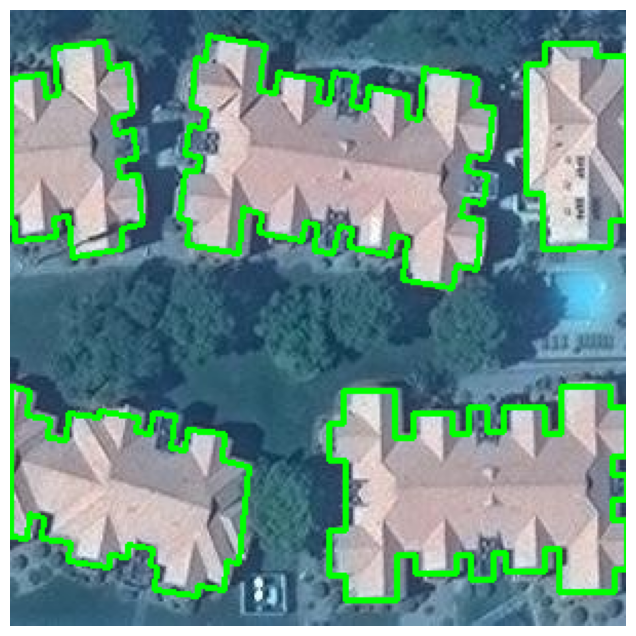

In [8]:
import cv2
import matplotlib.pyplot as plt

def plot_image_with_segmentation(image_path, yolo_label_path):
    # Carregar a imagem
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Obter as dimensões da imagem
    height, width, _ = image.shape

    # Ler as coordenadas de segmentação YOLO do arquivo de rótulo
    with open(yolo_label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Verificar se a linha não está vazia
        if line.strip():
            # Dividir a linha em valores
            values = line.strip().split()
            class_index = int(values[0])  # Índice da classe do objeto
            segmentations = [float(val) for val in values[1:]]  # Coordenadas de segmentação

            # Desenhar a segmentação na imagem
            pts = []
            for i in range(0, len(segmentations), 2):
                x = int(segmentations[i] * width)
                y = int(segmentations[i+1] * height)
                pts.append((x, y))

            # Conectar os pontos para formar a região segmentada
            pts = np.array(pts, np.int32)
            cv2.polylines(image_rgb, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

    # Plotar a imagem
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Exemplo de uso
image_path = '../ex3/output_images/000000001121.jpg'
yolo_label_path = '../ex3/output_labels/000000001121.txt'

plot_image_with_segmentation(image_path, yolo_label_path)


## SEPARANDO TREINO E TESTE

In [9]:
import os
import random
import shutil

def split_train_test(images_folder, labels_folder, train_folder, test_folder, split_ratio=0.8):
    # Crie as pastas de treino e teste se ainda não existirem
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'image'), exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'label'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'image'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'label'), exist_ok=True)

    # Obtenha a lista de nomes de arquivos de imagens
    image_files = os.listdir(images_folder)
    num_images = len(image_files)
    num_train_images = int(num_images * split_ratio)
    
    # Embaralhe a lista de arquivos de imagem
    random.shuffle(image_files)

    # Copie as imagens e os rótulos para as pastas de treino
    for image_file in image_files[:num_train_images]:
        image_path = os.path.join(images_folder, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        shutil.copy(image_path, os.path.join(train_folder, 'image'))
        shutil.copy(label_path, os.path.join(train_folder, 'label'))

    # Copie as imagens e os rótulos para as pastas de teste
    for image_file in image_files[num_train_images:]:
        image_path = os.path.join(images_folder, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        shutil.copy(image_path, os.path.join(test_folder, 'image'))
        shutil.copy(label_path, os.path.join(test_folder, 'label'))

# Defina os caminhos das pastas
images_folder = '../ex3/output_images/'
labels_folder = '../ex3/output_labels/'
train_folder = '../ex3/train'
test_folder = '../ex3/test'

# Divida as imagens e os rótulos em conjuntos de treino e teste
split_train_test(images_folder, labels_folder, train_folder, test_folder)


## TREINANDO MODELO YOLO

O treinamento será feito via google coolab devido restrições da minha maquina pessoal